# Gausiann process animation

## Imports

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import MinMaxScaler

## Useful functions

In [2]:
def create_random_sin_function(seed=42):
    np.random.seed(seed)

    x= np.linspace(start=0, stop=0.2, num=1000)
    # y = np.zeros_like(x)

    amplitudes = np.random.uniform(low=-1, high=1, size=4)
    periodes = np.random.uniform(low=2*np.pi, high=30*np.pi, size=4)
    phases = np.random.uniform(low=-np.pi, high=np.pi, size=4)

    y = (
            amplitudes[0]*np.sin(periodes[0]*(x) + phases[0]) 
            + amplitudes[1]*np.sin(periodes[1]*(x) + phases[1])
            + amplitudes[2]*np.sin(periodes[2]*(x) + phases[2])
            # + amplitudes[3]*np.sin(periodes[3]*(x) + phases[3])
        )
    
    y = MinMaxScaler(feature_range=(0,0.9)).fit_transform(y.reshape(-1, 1)).reshape(-1)
    x = MinMaxScaler(feature_range=(0,100)).fit_transform(x.reshape(-1, 1)).reshape(-1)
    
    # Reset random seed
    np.random.seed()

    return pd.DataFrame({'x':x, 'y':y})

def target_function():
    """
    Taken from https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb
    """
    x = np.linspace(-2, 10, 1000).reshape(-1, 1)
    y = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)
    y = MinMaxScaler(feature_range=(0,0.9)).fit_transform(y.reshape(-1, 1)).reshape(-1)
    x = MinMaxScaler(feature_range=(0,100)).fit_transform(x.reshape(-1, 1)).reshape(-1)
    return pd.DataFrame({'x':x, 'y':y})

## Code

### Create random function to map

<AxesSubplot: xlabel='x', ylabel='y'>

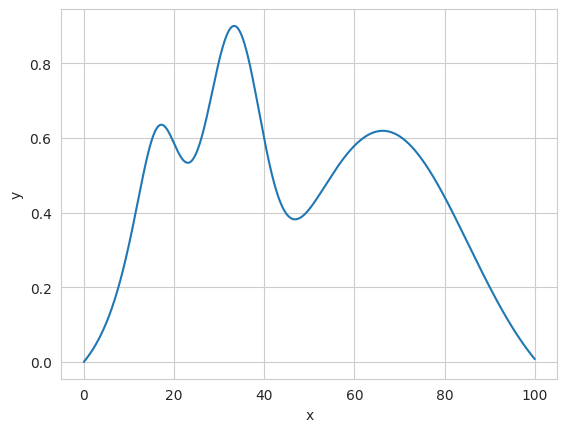

In [3]:
data = target_function()
sns.lineplot(data, x='x', y='y')

### Use Gaussian process to map function

/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


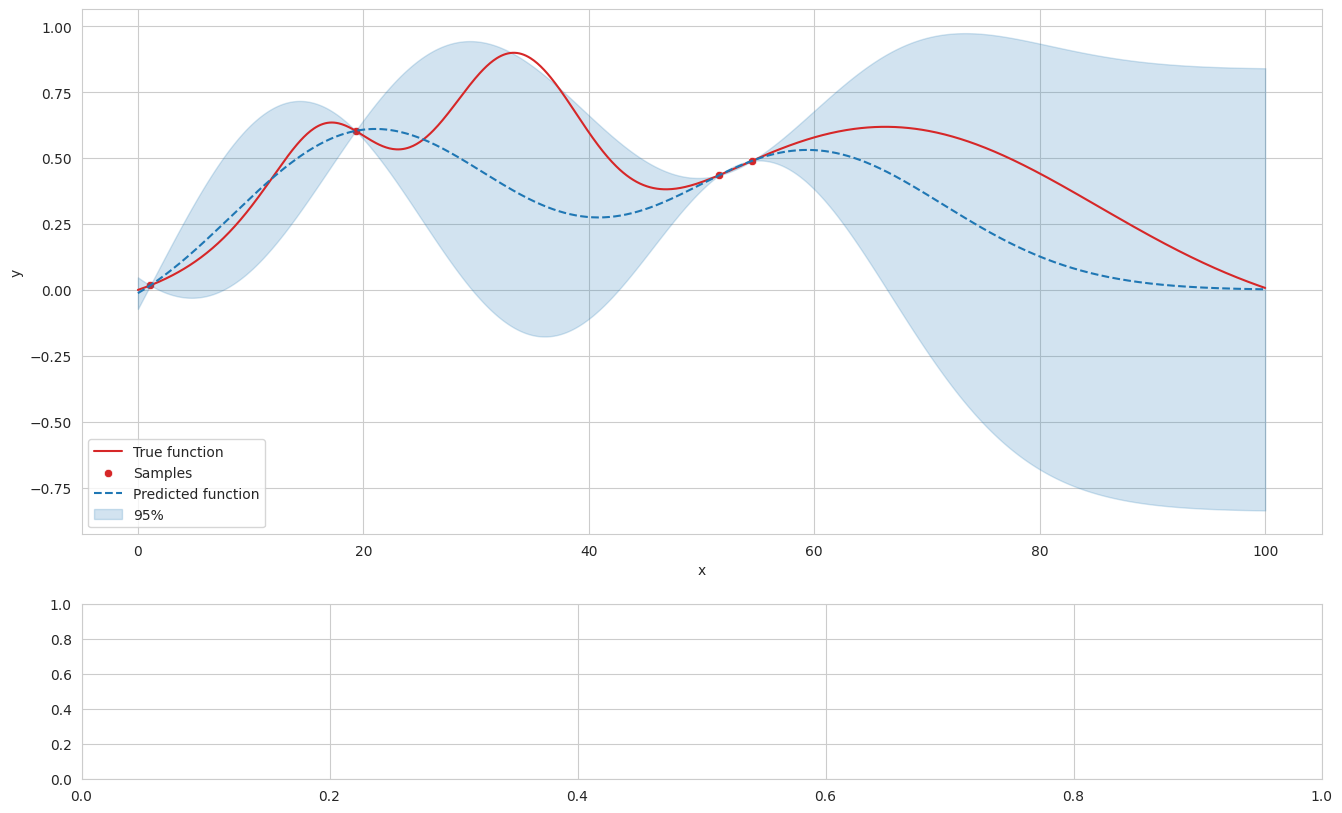

In [4]:
from matplotlib import gridspec
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

x = np.linspace(start=0, stop=100, num=1000)

kernel = 1.0*RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

random_samples = data.sample(n=4, random_state=5)
X_train, y_train = random_samples.drop(columns=['y']), random_samples['y']

gpr.fit(X_train, y_train)

mu, sig = gpr.predict(x.reshape(-1,1), return_std=True)

y_pred = mu

fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax = plt.subplot(gs[0])
acq = plt.subplot(gs[1])

sns.lineplot(x=data['x'], y=data['y'], label="True function", c=sns.color_palette()[3], ax=ax)
sns.scatterplot(random_samples, x='x', y='y', label="Samples", c=sns.color_palette()[3], ax=ax)

sns.lineplot(x=x, y=y_pred, linestyle="dashed", label="Predicted function", c=sns.color_palette()[0], ax=ax)
ax.fill_between(
    x=x, 
    y1=(y_pred - 2*sig), 
    y2=(y_pred + 2*sig), 
    color=sns.color_palette()[0], 
    alpha = 0.2, 
    label='95%'
)

ax.legend(loc='lower left')


### Bayesian Optimization

#### Acqustinction function

In [5]:
def upper_confidence_bound(mean:np.array, std:np.array, kappa=2.0) -> np.array:
    return mean + kappa*std

def bayesian_optimization_step(acquisition_function:np.array) -> np.int64:
    max_value_indexs = np.where(acquisition_function == np.amax(acquisition_function))

    if (len(max_value_indexs[0])==1):
        next_guess = max_value_indexs[0]
    else:
        next_guess = np.random.choice(max_value_indexs[0])
        
    return next_guess.item()


In [9]:
x = np.linspace(start=0, stop=100, num=1000)

kernel = 1.0*RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

iter = 12

samples = []

blue = sns.color_palette().as_hex()[0]
red = sns.color_palette().as_hex()[3]

np.random.seed(2)

for i in range(iter):

    # Start search with random training sample
    if len(samples)==0:
        idx = np.random.random_integers(0, x.shape[0])
        samples.append(idx)
    
    train = data.iloc[samples]

    # Create model
    gpr.fit(train['x'].values.reshape((-1,1)), train['y'])

    # Make prediction
    y_pred, std = gpr.predict(x.reshape(-1,1), return_std=True)
    
    # Calculate Acqustinction function
    ucb = upper_confidence_bound(y_pred, std)

    # Get next guess
    next_guess = bayesian_optimization_step(ucb)
    samples.append(next_guess)

    # Plot function
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    ax = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    ax.title.set_text('Bayesian optimization')
    acq.title.set_text('Acqustinction function')

    ## Bayesian optimalization
    sns.lineplot(x=data['x'], y=data['y'], label="True function", c=red, ax=ax)
    sns.scatterplot(train, x='x', y='y', label="Samples", c=red, ax=ax)

    sns.lineplot(x=x, y=y_pred, linestyle="dashed", label="Predicted function", c=blue, ax=ax)
    ax.fill_between(
        x=x, 
        y1=(y_pred - 2*std), 
        y2=(y_pred + 2*std), 
        color=blue, 
        alpha = 0.2, 
        label='95%'
    )

    next_sample = data.iloc[next_guess]

    ax.scatter(next_sample['x'], next_sample['y'], label="Next guess", c=blue)

    ax.legend(loc='upper right')
    
    ## Acqustinction function
    sns.lineplot(x=x, y=ucb, linestyle="dashed", label="Upper confidence bound", c=blue, ax=acq)
    acq.scatter(x=x[next_guess], y=ucb[next_guess], label="Next guess", c=blue)

    acq.legend(loc='upper right')

    
    # Adjust figure
    ax.set_ylim([-1.2, 1.6])
    acq.set_ylim([0, 1.5])

    # Save Figure
    FILENAME = f"graph-{i}.png"
    plt.savefig("./images/"+FILENAME)
    plt.close()


/tmp/ipykernel_644/3557806657.py:19: DeprecationWarning: This function is deprecated. Please call randint(0, 1000 + 1) instead
  idx = np.random.random_integers(0, x.shape[0])


## Resources
[Bayesian optimization with Gaussian processes](https://nbviewer.org/github/twolodzko/Learning/blob/main/Julia/Gaussian-Process.ipynb) (Julia Notebook)  
[Visualization example](https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb) (Python Notebook, BayesianOptimization)  
[An Introduction to Gaussian Process Regression](https://juanitorduz.github.io/gaussian_process_reg/) (Python, Blog)  
[Easy introduction to gaussian process regression (uncertainty models)](https://www.youtube.com/watch?v=iDzaoEwd0N0&ab_channel=paretos) (YouTube)  
[Coding gaussian process regressors FROM SCRATCH in python](https://www.youtube.com/watch?v=JXdrq7--XV0&ab_channel=paretos)  
[Bayesian Optimization](https://arxiv.org/pdf/1012.2599.pdf) (Paper, 2010)  
[Exploitation vs Exploration / Acquisition Functions](https://github.com/fmfn/BayesianOptimization/blob/master/examples/exploitation_vs_exploration.ipynb) (Python Notebook, BayesianOptimization)  
[Acquisition functions in Bayesian Optimization](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html#acquisition-functions)  

